<a href="https://colab.research.google.com/github/Adetayo047/Abosedeuk/blob/main/Intent_Recognition_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BERT RE-WRITTEN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.8 MB/s eta 0:00:00


In [3]:
# Reading Data from csvfiles
import pandas as pd
df = pd.read_excel('/content/drive/MyDrive/intent Recognition/Pidgin Intent.xlsx')
df.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me for 50 clásicos playlist,AddToPlaylist
2,I give this current textbook a rating value of...,RateBook
3,play the song small robin redbreast,PlayMusic
4,abeg add iris dement to my playlist this na se...,AddToPlaylist


In [4]:
#print the unique intents
df.intent.unique()

array(['PlayMusic', 'AddToPlaylist', 'RateBook', 'SearchScreeningEvent',
       'BookRestaurant', 'GetWeather', 'SearchCreativeWork'], dtype=object)

In [5]:
#print the count of intent
df.intent.value_counts()

AddToPlaylist           164
RateBook                151
GetWeather              143
PlayMusic               137
SearchCreativeWork      137
SearchScreeningEvent    136
BookRestaurant          132
Name: intent, dtype: int64

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

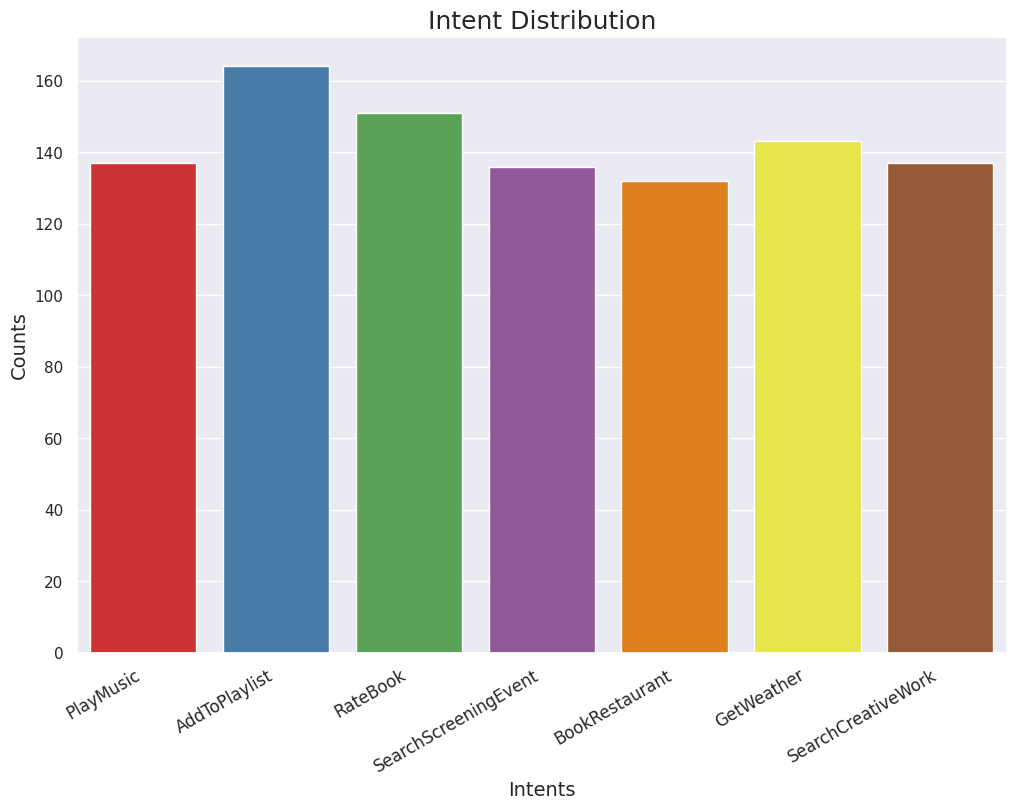

In [7]:
sns.set()
plt.figure(figsize = (12, 8))
chart = sns.countplot(x = 'intent', data = df, palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 30, horizontalalignment='right', fontweight='light', fontsize='medium')
chart.set_title('Intent Distribution', fontsize = 18)
chart.set_xlabel('Intents', fontsize = 14)
chart.set_ylabel('Counts', fontsize = 14)
plt.show()

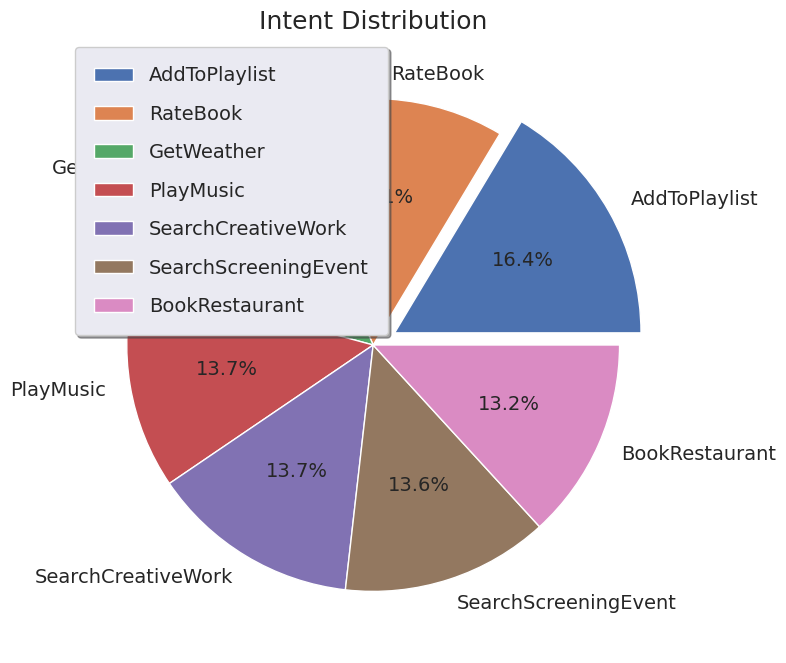

In [8]:
plt.figure(figsize = (12, 8))
data = df.intent.value_counts()
explode = (0.1, 0, 0, 0, 0, 0, 0)
ax  = data.plot.pie(autopct = '%1.1f%%', labels = data.index, explode = explode, fontsize = 14)
ax.set_title('Intent Distribution', fontsize = 18)
plt.axis('off')
ax.legend(labels = data.index, loc = "upper left", fontsize = 14, fancybox = True, labelspacing = 1, framealpha = 1, shadow=True, borderpad=1)
plt.show()

In [9]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [11]:
tokens = tokenizer.tokenize("Hello, how you dey?")
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(tokens)
print(token_ids)

['hello', ',', 'how', 'you', 'de', '##y', '?']
[7592, 1010, 2129, 2017, 2139, 2100, 1029]


# training our Bert on the Pidgin English datasets

In [58]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

df = pd.read_excel('/content/drive/MyDrive/intent Recognition/Pidgin Intent.xlsx')

# Split the data into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Label encode the intent labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train['intent_enc'] = le.fit_transform(train['intent'])
test['intent_enc'] = le.transform(test['intent'])

# Load the BERT tokenizer and encode the texts

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train['intent_enc'] = le.fit_transform(train['intent'])
test['intent_enc'] = le.fit_transform(test['intent'])


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(train.text), truncation=True, padding=True, return_tensors='tf')
test_encodings = tokenizer(list(test.text), truncation=True, padding=True, return_tensors='tf')

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train.intent_enc))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test.intent_enc))

# Fine-tune the pre-trained BERT model for intent recognition
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=train['intent_enc'].nunique())
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# # Train the model
# model.fit(train_dataset.shuffle(len(train.text)).batch(32), epochs=10, batch_size=32)



# Training history
history = model.fit(train_dataset.shuffle(len(train.text)).batch(32), epochs=10, batch_size=32, validation_data=test_dataset.batch(32))



All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
25/25 [==============================] - 67s 529ms/step - loss: 1.6990 - accuracy: 0.4338 - val_loss: 1.3489 - val_accuracy: 0.7350
Epoch 2/10
25/25 [==============================] - 8s 339ms/step - loss: 1.1211 - accuracy: 0.8375 - val_loss: 0.7943 - val_accuracy: 0.9400
Epoch 3/10
25/25 [==============================] - 8s 300ms/step - loss: 0.6315 - accuracy: 0.9600 - val_loss: 0.4312 - val_accuracy: 0.9600
Epoch 4/10
25/25 [==============================] - 5s 220ms/step - loss: 0.3327 - accuracy: 0.9812 - val_loss: 0.2610 - val_accuracy: 0.9550
Epoch 5/10
25/25 [==============================] - 6s 228ms/step - loss: 0.1881 - accuracy: 0.9875 - val_loss: 0.1811 - val_accuracy: 0.9750
Epoch 6/10
25/25 [==============================] - 7s 270ms/step - loss: 0.1108 - accuracy: 0.9925 - val_loss: 0.1549 - val_accuracy: 0.9750
Epoch 7/10
25/25 [==============================] - 6s 233ms/step - loss: 0.0765 - accuracy: 0.9937 - val_loss: 0.1563 - val_accuracy: 0.9700
Epoch

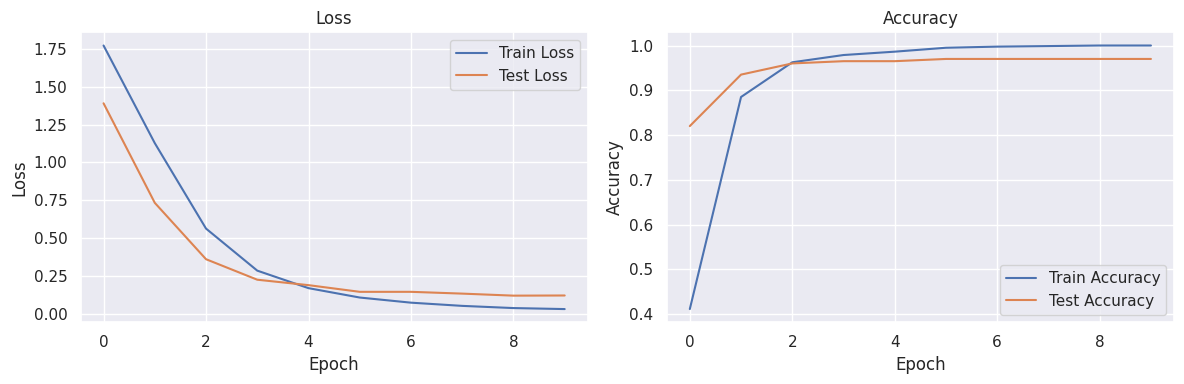

In [13]:
# Plot loss and accuracy
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [50]:
# Model summary
model.summary()

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_151 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  5383      
                                                                 
Total params: 109,487,623
Trainable params: 109,487,623
Non-trainable params: 0
_________________________________________________________________


In [59]:
# Evaluate the model on the test set
results = model.evaluate(test_dataset.batch(32))
print("Test accuracy:", results[1])

7/7 [==============================] - 1s 85ms/step - loss: 0.1417 - accuracy: 0.9700
Test accuracy: 0.9700000286102295


In [16]:
from sklearn.metrics import classification_report
# Generate predictions on the test set
test_predictions = model.predict(test_dataset.batch(32))
test_pred_labels = tf.argmax(test_predictions.logits, axis=1)

# Convert encoded labels back to original labels
test_pred_labels_orig = le.inverse_transform(test_pred_labels)
test_true_labels_orig = le.inverse_transform(test['intent_enc'])

# Print classification report
print(classification_report(test_true_labels_orig, test_pred_labels_orig))

7/7 [==============================] - 3s 92ms/step
                      precision    recall  f1-score   support

       AddToPlaylist       1.00      1.00      1.00        35
      BookRestaurant       0.94      1.00      0.97        30
          GetWeather       0.96      0.96      0.96        24
           PlayMusic       0.95      1.00      0.98        20
            RateBook       1.00      1.00      1.00        34
  SearchCreativeWork       1.00      0.85      0.92        27
SearchScreeningEvent       0.94      0.97      0.95        30

            accuracy                           0.97       200
           macro avg       0.97      0.97      0.97       200
        weighted avg       0.97      0.97      0.97       200



In [17]:
model.save_pretrained('bertmodelintent')

# Optionally, you can save the tokenizer as well
tokenizer.save_pretrained('berttokenizer')

('berttokenizer/tokenizer_config.json',
 'berttokenizer/special_tokens_map.json',
 'berttokenizer/vocab.txt',
 'berttokenizer/added_tokens.json')

In [18]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer

# Load the model from the saved directory
model = TFBertForSequenceClassification.from_pretrained('bertmodelintent')

# Optionally, load the tokenizer as well
tokenizer = BertTokenizer.from_pretrained('berttokenizer')

# Function to predict intent from a given text
def predict_intent(text):
    # Tokenize the text
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors='tf')

    # Get the model's prediction
    predictions = model(inputs)[0]
    predicted_label_id = tf.argmax(predictions, axis=1).numpy()[0]

    return le.inverse_transform([predicted_label_id])[0]

# Example usage


Some layers from the model checkpoint at bertmodelintent were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at bertmodelintent.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [19]:
for i in test.text[:10]:
  predicted_intent = predict_intent(i)
  print(i+":",predicted_intent)


I go give this novel rating of two: RateBook
tell me the weather forecast for carmichaels gambia at one am: GetWeather
add the tune to my chill hits playlist: AddToPlaylist
find tv show wey dem dey call ride the wind: SearchCreativeWork
play russell morris the singer and the song for netflix: PlayMusic
add this song to brooklyn beat: AddToPlaylist
watin be the closest movie house dey show night for may: SearchScreeningEvent
find movie schedule for nearby films: SearchScreeningEvent
find the schedule for across the line for the closest movie house: SearchScreeningEvent
she don dey movie times: SearchScreeningEvent


## Comparing Bert Model with other models

In [60]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN
import matplotlib.pyplot as plt

# Tokenize and pad the text data
max_words = 1000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train['text'])
train_sequences = tokenizer.texts_to_sequences(train['text'])
test_sequences = tokenizer.texts_to_sequences(test['text'])
max_sequence_length = max(len(seq) for seq in train_sequences)
train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_padded, train['intent_enc']))
test_dataset = tf.data.Dataset.from_tensor_slices((test_padded, test['intent_enc']))

# LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length),
    LSTM(128),
    Dense(train['intent_enc'].nunique(), activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_history = lstm_model.fit(train_dataset.batch(32), epochs=10, validation_data=test_dataset.batch(32))

# RNN Model
rnn_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length),
    SimpleRNN(128),
    Dense(train['intent_enc'].nunique(), activation='softmax')
])

rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn_history = rnn_model.fit(train_dataset.batch(32), epochs=10, validation_data=test_dataset.batch(32))


Epoch 1/10
25/25 [==============================] - 7s 174ms/step - loss: 1.9412 - accuracy: 0.1475 - val_loss: 1.8850 - val_accuracy: 0.2450
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 1.4837 - accuracy: 0.3600 - val_loss: 1.1375 - val_accuracy: 0.5350
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 0.8305 - accuracy: 0.6325 - val_loss: 0.6853 - val_accuracy: 0.7000
Epoch 4/10
25/25 [==============================] - 0s 7ms/step - loss: 0.5169 - accuracy: 0.7875 - val_loss: 0.4217 - val_accuracy: 0.8750
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 0.2322 - accuracy: 0.9275 - val_loss: 0.3284 - val_accuracy: 0.9200
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 0.1285 - accuracy: 0.9650 - val_loss: 0.3989 - val_accuracy: 0.9050
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 0.1900 - accuracy: 0.9438 - val_loss: 0.5392 - val_accuracy: 0.8850
Epoch 8/10
25/25 [

In [63]:
# Evaluate all three models

print("\nLSTM Model Evaluation:")
lstm_results = lstm_model.evaluate(test_dataset.batch(32))
print("Test accuracy:", lstm_results[1])

print("\nRNN Model Evaluation:")
rnn_results = rnn_model.evaluate(test_dataset.batch(32))
print("Test accuracy:", rnn_results[1])

print("BERT-based Model Evaluation:")
print("Test accuracy:", results[1])
# Create a comparison table
comparison_data = {
    'Model': ['BERT-IRP', 'LSTM', 'RNN'],
    'Test Accuracy': [results[1],lstm_results[1], rnn_results[1]]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nComparison of Models:")
print(comparison_df)


LSTM Model Evaluation:
7/7 [==============================] - 0s 5ms/step - loss: 0.4042 - accuracy: 0.9100
Test accuracy: 0.9100000262260437

RNN Model Evaluation:
7/7 [==============================] - 0s 10ms/step - loss: 0.3861 - accuracy: 0.9050
Test accuracy: 0.9049999713897705
BERT-based Model Evaluation:
Test accuracy: 0.9700000286102295

Comparison of Models:
      Model  Test Accuracy
0  BERT-IRP          0.970
1      LSTM          0.910
2       RNN          0.905
